# Monitoring Mangrove Extents

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a),
[gmw](https://explorer.digitalearth.africa/gmw)

## Background
[Global Mangrove Watch (GMW)](https://www.globalmangrovewatch.org/) is an initiative to track global mangrove extents. Using ALOS PALSAR and Landsat (optical) data to form a baseline extent of mangroves for the years 1996, 2007, 2008, 2009, 2010, 2015, and 2016 . More detailed information on the initiative can be found [here](http://data.unep-wcmc.org/datasets/45). This dataset has been rasterized and indexed into DE Africa's Open Data Cube, for more information on how to load this dataset check out the [GMW Datasets](../Datasets/Global_Mangrove_Watch.ipynb) notebook.


## Description
The goal of this notebook is to monitor the changing extent of mangroves, using the GMW layers as a baseline mask.

The process begins with retrieving Sentnel-2 data for a specific area in a time series. This dataset is then compressed into a [median](../Frequently_used_code/Generating_composites.ipynb) composite for each year. From the composite, we then calculate the NDVI values of each pixel in each year. The dataset is then masked, and the NDVI threshold is applied for mangrove classification. The following image shows the decision tree for the classification.

<img align="center" src="../Supplementary_data/Mangroves_analysis/mangrove_decision_tree.png" width=600>



After classification, we can perform a variety of analyses on the data:
- We can estimate the change in mangrove areas by counting all the classified pixels for each year and plotting the trend line of the count. 
- We can also visualize the mangrove areas by plotting each classified pixel a certain color. 

## Getting started

**To run this analysis**, run all the cells in the notebook, starting with the [Load packages](#Load-packages) cell.

**After finishing the analysis**, return to the [Analysis parameters](#Analysis-parameters) cell, modify some values (e.g. choose a your own mangrove shapefile or time period to analyse) and re-run the analysis.

### Load packages

In [1]:
%matplotlib inline

import warnings
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils import geometry
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.coastal import tidal_tag
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map

### Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:41297 Dashboard: /user/victoria@kartoza.com/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


### Load the data

Connect to the datacube database and set up a processing cluster.

In [3]:
dc = datacube.Datacube(app="Mangrove")

### Analysis parameters

* `lat, lon, buffer`: center lat/lon and analysis window size for the area of interest
* `product_name`: The name of the satellite product to use.
* `time_range`: The date range to analyse (e.g. `("2017", "2020")`).
* `tide_range`: The minimum and maximum proportion of the tidal range to include in the analysis. For example, `tide_range = (0.25, 0.75)` will select all satellite images taken during mid-tide conditions (i.e. 25th to 75th percentile range). This allows us to remove any impact of tides on the classification of mangrove extent. Also, because Sentinel-2 is a sun-synchronoous sensor, the mid-tide is observed more than low and high tides, therefore it is advantageous to use the mid-tide extent as we will retain more satellite images.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.


In [4]:
lat,lon = 11.88, -15.8558

buffer = 0.15

product_name = "s2_l2a"

time_range = ("2017", "2021")

tide_range = (0.25, 0.75) # only keep mid tides

#join lat, lon, buffer to get bounding box
lon_range = (lon - buffer, lon + buffer)
lat_range = (lat + buffer, lat - buffer)


### View the selected location

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(lon_range, lat_range)

## Load cloud-masked Sentinel-2 data

The code below uses the `load_ard` function to load in data from the Sentinel-2 satellites for the area and time specified.
For more information, see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).
The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:

In [6]:
# create a query dict for the datacube
query = {
    "time": time_range,
    'x': lon_range,
    'y': lat_range,
    "group_by": "solar_day",
    "resolution": (-20, 20),
    "output_crs":"EPSG:6933",
}

# load data
ds = load_ard(
    dc=dc,
    products=[product_name],
    measurements=["red", "nir_2"], #use nir-narrow for NDVI
    mask_filters=[("opening", 5), ("dilation", 5)],
    dask_chunks={"time": 1, "x": 1000, "y": 1000},
    **query,
)
print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying morphological filters to pq mask [('opening', 5), ('dilation', 5)]
Applying pixel quality/cloud mask
Returning 344 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 344, y: 1875, x: 1449)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-05T11:27:37 ... 2021-12-30T11:...
  * y            (y) float64 1.524e+06 1.524e+06 ... 1.486e+06 1.486e+06
  * x            (x) float64 -1.544e+06 -1.544e+06 ... -1.515e+06 -1.515e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir_2        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Load in the Global Mangrove Watch

Below we load the latest GMW layer, which is from 2016

In [7]:
gmw = dc.load(product='gmw',
              time='2016',
              like=ds.geobox)

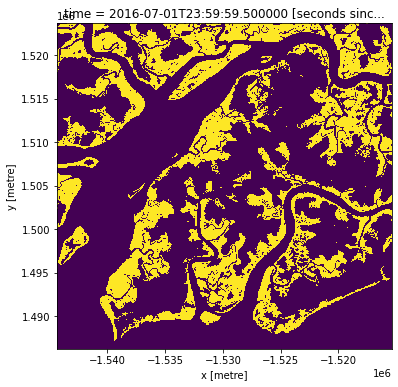

In [8]:
gmw.mangrove.plot(figsize=(6,6), add_colorbar=False);

## Model tide heights

The location of the shoreline can vary greatly from low to high tide, which may impact the NDVI values of pixels where water and mangroves intermingle. In the code below, we aim to reduce the effect of tides by modelling tide height data, and keeping only the satellite images that were taken at specific tidal conditions. For example, if `tide_range = (0.00, 0.50)`, we are telling the analysis to focus only on satellite images taken when the tide was between the lowest tidal conditions and the median (50th percentile) conditions.

The tidal_tag function below uses the [OTPS TPXO8 tidal model](https://www.tpxo.net/global/tpxo8-atlas) to calculate the height of the tide at the exact moment each satellite image in our dataset was taken, and adds this as a new tide_height attribute in our dataset.

> **Important note**: this function can only model tides correctly if the centre of your study area is located over water. If this isn't the case, you can specify a custom tide modelling location by passing a coordinate to `tidepost_lat` and `tidepost_lon` (e.g. tidepost_lat=14.283, tidepost_lon=-16.921).  If you are not running the default analysis, then either change the `tidepost_lat` and `tidepost_lon` below to a location over the ocean near your study-area, or try setting them to `None` and see if the code can infer the location of your study-area


In [9]:
tidepost_lat=11.7443
tidepost_lon=-15.9949

In [10]:
# Calculate tides for each timestep in the satellite dataset
ds = tidal_tag(ds=ds, tidepost_lat=tidepost_lat, tidepost_lon=tidepost_lon)

# Print the output dataset with new `tide_height` variable
print(ds)

Using user-supplied tide modelling location: -15.99, 11.74
<xarray.Dataset>
Dimensions:      (time: 344, y: 1875, x: 1449)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-05T11:27:37 ... 2021-12-30T11:...
  * y            (y) float64 1.524e+06 1.524e+06 ... 1.486e+06 1.486e+06
  * x            (x) float64 -1.544e+06 -1.544e+06 ... -1.515e+06 -1.515e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir_2        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    tide_height  (time) float64 -0.669 0.398 0.301 ... 0.616 -0.357 -0.193
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


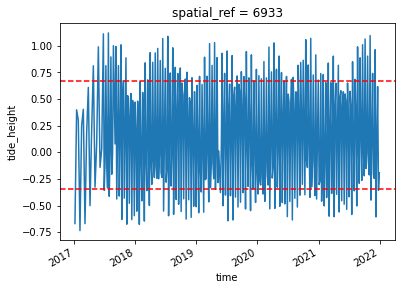

In [11]:
# Calculate the min and max tide heights to include based on the % range
min_tide, max_tide = ds.tide_height.quantile(tide_range)

# Plot the resulting tide heights for each Landsat image:
ds.tide_height.plot()
plt.axhline(min_tide, c="red", linestyle="--")
plt.axhline(max_tide, c="red", linestyle="--")
plt.show()

### Filter satellite images by tide height

Here we take the dataset and only keep the images with tide heights we want to analyse (i.e. tides within the heights given by `tide_range`). This will result in a smaller number of images.


In [12]:
# Keep timesteps larger than the min tide, and smaller than the max tide
ds_filtered = ds.sel(time=(ds.tide_height > min_tide) & (ds.tide_height <= max_tide))
print(ds_filtered)

<xarray.Dataset>
Dimensions:      (time: 172, y: 1875, x: 1449)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-15T11:34:00 ... 2021-12-30T11:...
  * y            (y) float64 1.524e+06 1.524e+06 ... 1.486e+06 1.486e+06
  * x            (x) float64 -1.544e+06 -1.544e+06 ... -1.515e+06 -1.515e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir_2        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    tide_height  (time) float64 0.398 0.301 0.248 0.403 ... 0.079 0.616 -0.193
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Combine observations into noise-free summary images

In the code below, we take the time series of images and combine them into single images for each year using the `median NDVI`. The *Normalised Difference Vegetation Index* (NDVI) shows vegetation and is used for mangrove classification within the mangrove mask.

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

For more information on indices, see the [Calculating Band Indices](../Frequently_used_code/Calculating_band_indices.ipynb) notebook.


> Note: This step can take several minutes to load if the study area is large. We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the Dask dashboard in DE Africa section of the Dask notebook.

In [13]:
#calculate NDVI, rename nir2 to trick calculate_indices
ds_filtered = ds_filtered.rename({'nir_2':'nir'})
ds_filtered = calculate_indices(ds_filtered, index='NDVI', satellite_mission='s2')

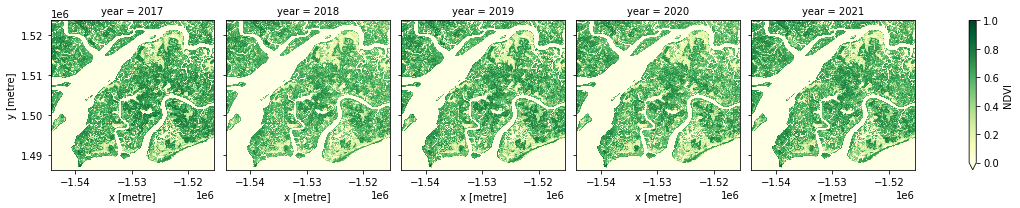

In [14]:
# generate median annual summaries of NDVI
ds_summaries = ds_filtered.NDVI.groupby("time.year").median().compute()

# Plot the output summary images
ds_summaries.plot(col="year", cmap="YlGn", col_wrap=len(ds_summaries.year.values), vmin=0, vmax=1.0);

## Mangrove classification

### Apply a mask of the mangrove area

We will use the mangrove mask from the Global Mangrove Watch dataset so we can work with only the pixels in the mangrove area.  

In [15]:
# Mask dataset to set pixels outside the GMW layer to `NaN`
ds_summaries_masked = ds_summaries.where(gmw.mangrove.squeeze())

### Calculating regular and closed mangroves

Using the [mangrove decision tree](#Description) above, we can classify the pixels as:

* **mangroves:** pixels in the mangrove area with an `NDVI > 0.4`
    * **regular mangroves:** mangroves with `NDVI <= 0.7`
    * **closed mangroves:** mangroves with `NDVI > 0.7`

In [16]:
all_mangroves = xr.where(ds_summaries_masked > 0.4, 1, np.nan)

regular_mangroves = all_mangroves.where(ds_summaries_masked <= 0.7)
closed_mangroves = all_mangroves.where(ds_summaries_masked > 0.7)

### Plot the mangrove types

Again we will combine the mangrove types for easier plotting.

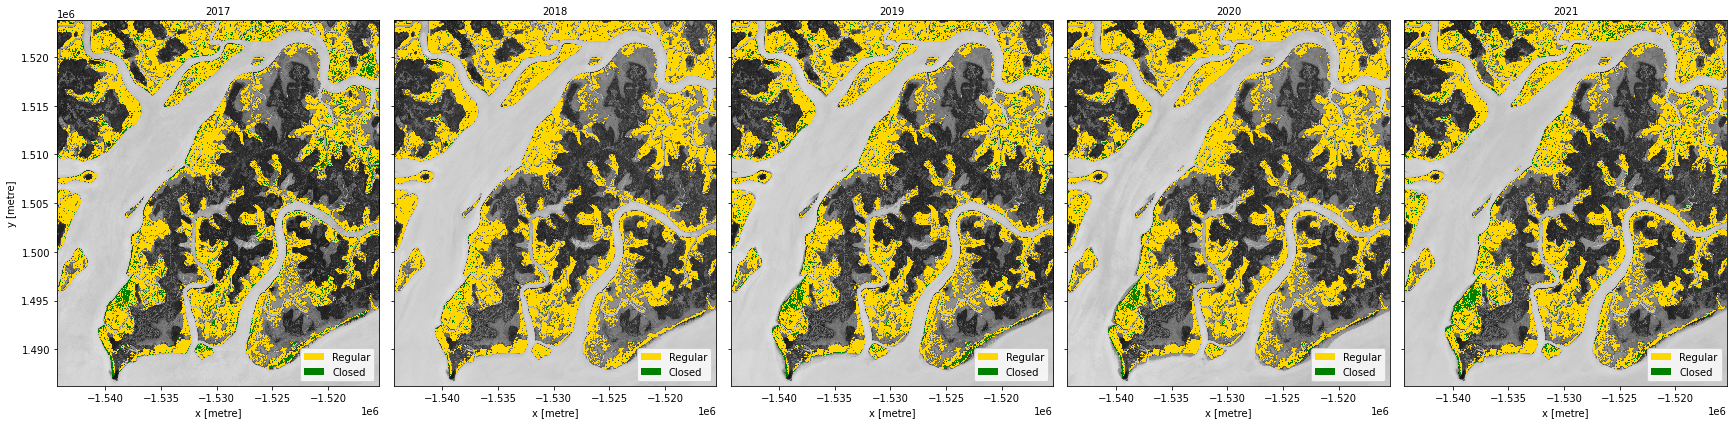

In [17]:
mangroves = xr.concat(
    [regular_mangroves, closed_mangroves, all_mangroves],
    dim=pd.Index(["regular", "closed", "total"], name="mangrove_type"),
)

regular_color = "gold"
closed_color = "green"

# Create a FacetGrid, so there is a subplot for each year
grid = xr.plot.FacetGrid(
    mangroves,
    col="year",
    col_wrap=len(ds_summaries.year.values),
    size=6,
    aspect=mangroves.x.size / mangroves.y.size,
)

# Define the sub-plot of mangrove types with a legend on a background of grey-scale NDVI
def plot_mangrove(data, ax, **kwargs):
    ds_summaries.sel(year=data.year).plot.imshow(
        ax=ax, cmap="Greys", vmin=-1, vmax=1, add_colorbar=False, add_labels=False
    )
    data.sel(mangrove_type="regular").plot.imshow(
        ax=ax,
        cmap=ListedColormap([regular_color]),
        add_colorbar=False,
        add_labels=False,
    )
    data.sel(mangrove_type="closed").plot.imshow(
        ax=ax, cmap=ListedColormap([closed_color]), add_colorbar=False, add_labels=False
    )

    ax.legend(
        [Patch(facecolor=regular_color), Patch(facecolor=closed_color)],
        ["Regular", "Closed"],
        loc="lower right",
    )

# Plot the each year sub-plot
grid.map_dataarray(plot_mangrove, x="x", y="y", add_colorbar=False)

# Update sub-plot titles
for i, name in np.ndenumerate(grid.name_dicts):
    grid.axes[i].title.set_text(str(name["year"]));

## Mangrove change
### Plot the change of mangrove classification in area over time

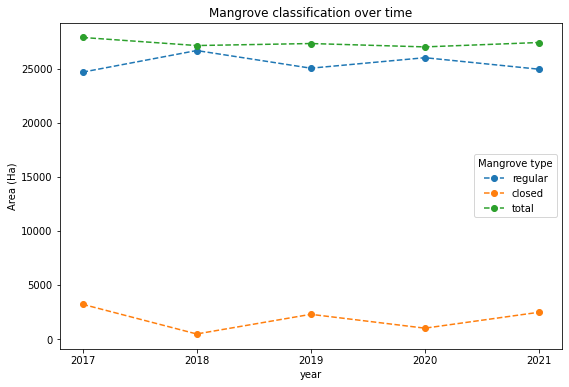

In [18]:
# Convert pixel count to km^2
m2_per_ha = 10000
m2_per_pixel = query["resolution"][1] ** 2
mangrove_area = mangroves.sum(dim=("x", "y")) * m2_per_pixel / m2_per_ha

# Fix axis and legend text
mangrove_area.name = r"Area (Ha)"
mangrove_area = mangrove_area.rename(mangrove_type="Mangrove type")

# Plot the line graph
mangrove_area.plot(
    hue="Mangrove type",
    x="year",
    xticks=mangrove_area.year,
    size=6,
    linestyle="--",
    marker="o",
)
plt.title("Mangrove classification over time");

### Monitoring change in mangroves

We can calculate the growth and loss of mangroves between the first and last year in our timeseries

In [19]:
total_mangroves = (mangroves.loc["total"] == 1).astype(int)

# Calculate the change in mangrove extent
old = total_mangroves.isel(year=0)
new = total_mangroves.isel(year=-1)
change = new - old

# reclassify into growth, loss and stable
growth = xr.where(change == 1, 1, np.nan)
loss = xr.where(change == -1, -1, np.nan)
stable = old.where(~change)
stable = xr.where(stable == 1, 1, np.nan)

#### Plot the change

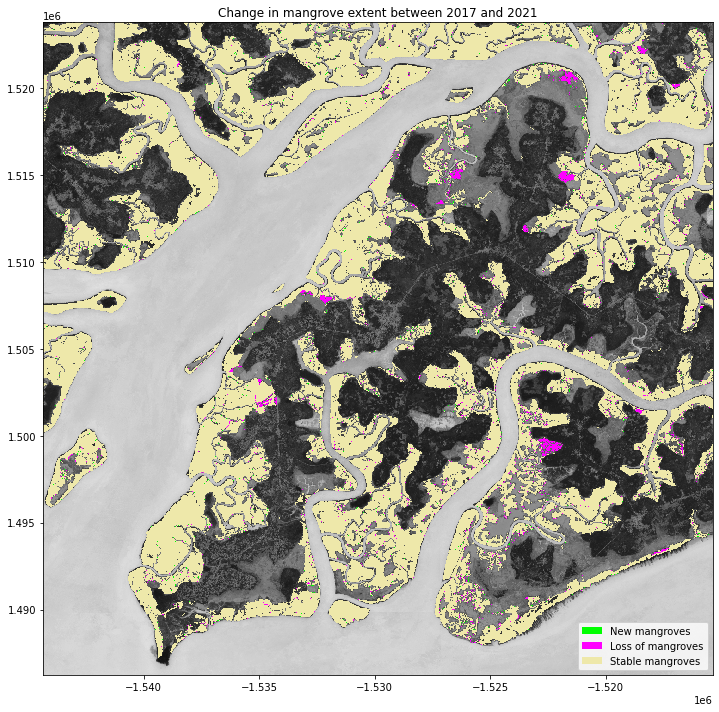

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ds_summaries.isel(year=0).plot.imshow(
    ax=ax, cmap="Greys", vmin=-1, vmax=1, add_colorbar=False, add_labels=False
)
stable.plot(
    ax=ax, cmap=ListedColormap(["palegoldenrod"]), add_colorbar=False, add_labels=False
)
growth.squeeze().plot.imshow(
    ax=ax, cmap=ListedColormap(["lime"]), add_colorbar=False, add_labels=False
)
loss.plot.imshow(
    ax=ax, cmap=ListedColormap(["fuchsia"]), add_colorbar=False, add_labels=False
)
ax.legend(
    [
        Patch(facecolor='lime'),
        Patch(facecolor='fuchsia'),
        Patch(facecolor="palegoldenrod"),
    ],
    ["New mangroves", "Loss of mangroves", "Stable mangroves"],
    loc="lower right",
)
plt.title('Change in mangrove extent between {} and {}'.format(ds_summaries.year.values[0], ds_summaries.year.values[-1]));

### Determine the net change between years

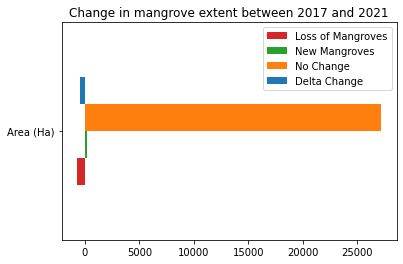

In [21]:
loss_count = loss.sum().values * m2_per_pixel / m2_per_ha
gain_count = growth.sum().values * m2_per_pixel / m2_per_ha
stable_count = stable.sum().values* m2_per_pixel / m2_per_ha

counts = {
          'Loss of Mangroves': loss_count,
          'New Mangroves': gain_count,
          'No Change': stable_count,
          'Delta Change': gain_count + loss_count
          }

df = pd.DataFrame(counts, index=['Area (Ha)'])
df.plot.barh(color=['tab:red','tab:green','tab:orange','tab:blue'])
plt.title('Change in mangrove extent between {} and {}'.format(ds_summaries.year.values[0], ds_summaries.year.values[-1]));


## Advanced: Compare Recent Mangrove Extent to GMW 1996

In the previous plots, we were calculating the change in mangrove extent from the start of the Sentinel-2 time series (2017) until now (2021). However, the baseline mangrove extent map, the Global Mangrove Watch (GMW) layer goes all the way back to 1996. Thus, the mangrove extent may have change significantly between 1996 and the beginning of the Sentinel-2 archive.  We can use the GMW layer to inspect how mangrove extent has changed since the development of the 2016 product that we examined above. 

A word of caution here, the GMW product was developed using a different methodology to the one used here, so differences in mangrove extent may be attributable to the different methods. Nevertheless, this should still provide us with a reasonable indication of the changes that have occurred between 1996 and the beginning of the Sentinel-2 archive in 2017.

### Load the earliest GMW layer

In [22]:
gmw_1996 = dc.load(product='gmw',
              time='1996',
              like=ds.geobox)

### Determine change between 1996 and 2017

In [23]:
#Find the change between now and the baseline
baseline_change = old - gmw_1996.mangrove.squeeze()

# reclassify into growth, loss and stable
growth_bs = xr.where(baseline_change == 1, 1, np.nan)
loss_bs = xr.where(baseline_change == -1, -1, np.nan)
stable_bs = gmw_1996.mangrove.squeeze().where(~baseline_change)
stable_bs = xr.where(stable == 1, 1, np.nan)

#### Plot the change

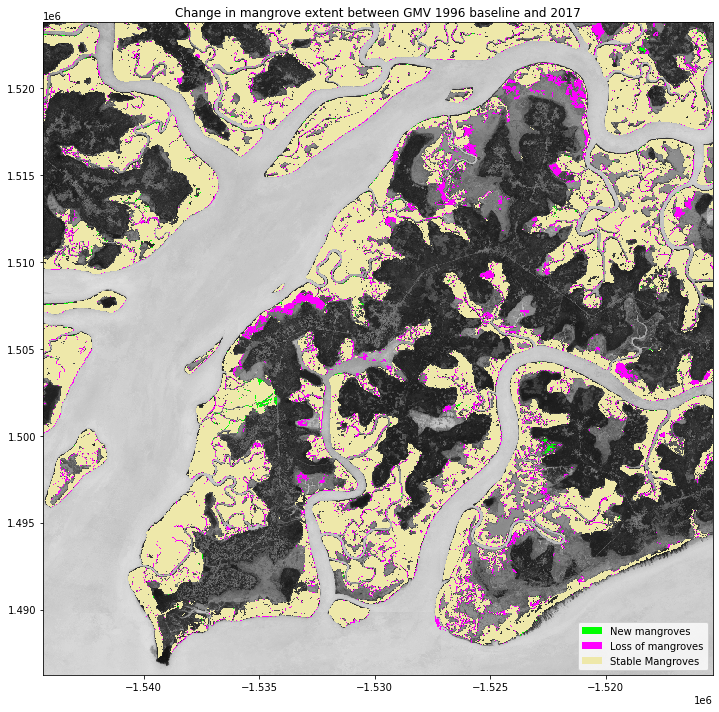

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ds_summaries.isel(year=0).plot.imshow(
    ax=ax, cmap="Greys", vmin=-1, vmax=1, add_colorbar=False, add_labels=False
)
stable_bs.plot(
    ax=ax, cmap=ListedColormap(["palegoldenrod"]), add_colorbar=False, add_labels=False
)
growth_bs.plot.imshow(
    ax=ax, cmap=ListedColormap(["lime"]), add_colorbar=False, add_labels=False
)
loss_bs.plot.imshow(
    ax=ax, cmap=ListedColormap(["fuchsia"]), add_colorbar=False, add_labels=False
)
ax.legend(
    [
        Patch(facecolor='lime'),
        Patch(facecolor='fuchsia'),
        Patch(facecolor="palegoldenrod"),
    ],
    ["New mangroves", "Loss of mangroves", "Stable Mangroves"],
    loc="lower right",
)
plt.title('Change in mangrove extent between GMV 1996 baseline and {}'.format(ds_summaries.year.values[0]));

### Determine the net change between 1996 and 2017

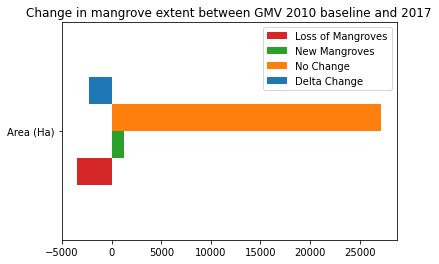

In [25]:
loss_bs_count = loss_bs.sum().values * m2_per_pixel / m2_per_ha
gain_bs_count = growth_bs.sum().values * m2_per_pixel / m2_per_ha
stable_bs_count = stable_bs.sum().values* m2_per_pixel / m2_per_ha

counts = {
          'Loss of Mangroves': loss_bs_count,
          'New Mangroves': gain_bs_count,
          'No Change': stable_bs_count,
          'Delta Change': gain_bs_count + loss_bs_count
          }

df = pd.DataFrame(counts, index=['Area (Ha)'])
df.plot.barh(color=['tab:red','tab:green','tab:orange','tab:blue'])
plt.title('Change in mangrove extent between GMV 2010 baseline and {}'.format(ds_summaries.year.values[0]));

## Drawing conclusions
Here are some questions to think about:

* What are the causes of mangrove growth and loss? 

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [26]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [27]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-07-07'